In [7]:
# Modules for debugging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from joblib import parallel_backend


# Custom modules
from preprocessing_post_fastsurfer.alignment import *
from preprocessing_post_fastsurfer.cropping import *
from preprocessing_post_fastsurfer.extraction import *
from preprocessing_post_fastsurfer.file_handling import *
from preprocessing_post_fastsurfer.mesh_creation import *
from preprocessing_post_fastsurfer.subject import *
from preprocessing_post_fastsurfer.vis import *

# Custom modules
from ozzy_torch_utils.split_dataset import *
from ozzy_torch_utils.subject_dataset import *

np.set_printoptions(precision=2, suppress=True)

In [8]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort"

selected_labels = ['CN', 'MCI']

# Dictionary key representing the disease labels
labels_string = 'research_group'

test_size = 0.3


In [9]:
dataset = SubjectDataset(data_path, selected_labels)

In [10]:

print(dataset[10]['volumes'])

print(dataset[10]['struct_names'])

[217.29  17.09   1.37  13.02  47.11   6.69   2.8    4.04   1.93   1.97
   1.27  20.3    3.32   1.17   1.36   0.39   3.87   1.11 217.38  11.09
   1.12  12.67  48.56   6.74   2.88   4.13   1.89   3.4    1.23   0.49
   3.79   1.15   1.86   0.     0.     0.     0.     0.     2.64   5.57
   3.13   1.4    5.68   6.93   7.51   1.62   8.51   5.83   5.89   3.48
   7.21   1.58   3.93   2.62   1.86   2.27   1.23   7.09   3.09  11.1
   6.06   2.76   8.08  17.66   6.93  11.47   6.91   0.73   4.51   1.24
   4.71   2.72   1.1    7.12   9.79   7.58   1.48   9.63   6.21   4.84
   3.53   7.98   1.53   3.47   3.01   1.61   3.56   1.48   7.21   2.97
   9.97   6.78   2.12   8.51  20.18   7.23  12.02   5.29   0.68   4.71]
['Left-Cerebral-White-Matter' 'Left-Lateral-Ventricle' 'Left-Inf-Lat-Vent'
 'Left-Cerebellum-White-Matter' 'Left-Cerebellum-Cortex' 'Left-Thalamus'
 'Left-Caudate' 'Left-Putamen' 'Left-Pallidum' '3rd-Ventricle'
 '4th-Ventricle' 'Brain-Stem' 'Left-Hippocampus' 'Left-Amygdala' 'CSF'
 'Left-A

In [11]:
labels = [dataset[index]['research_group'] for index in range(len(dataset.subject_list))]

volumes = [dataset[index]['volumes'] for index in range(len(dataset.subject_list))]

print(f"Unique labels: {np.unique(labels, return_counts=True)}\n")

Unique labels: (array([0, 1]), array([207, 371]))



In [12]:

with parallel_backend('threading', n_jobs=8):

    model = GradientBoostingClassifier(n_estimators=4, learning_rate=0.1, max_depth=3)

    # Need to implement k fold with non-leakage datasets, there could be leakage here if single_img_per_subject is not selected
    cv = StratifiedKFold(n_splits=10, shuffle=True)

    cv_scores = cross_val_score(model, volumes, labels, cv=cv, scoring='accuracy')

    print(f'Cross-validation accuracy scores: {cv_scores}')
    print(f'Mean cross-validation accuracy: {np.mean(cv_scores)}')
    print(f'Standard deviation of cross-validation accuracy: {np.std(cv_scores)}')

Cross-validation accuracy scores: [0.64 0.64 0.66 0.62 0.64 0.62 0.69 0.66 0.65 0.65]
Mean cross-validation accuracy: 0.6453418027828192
Standard deviation of cross-validation accuracy: 0.01888323003029502


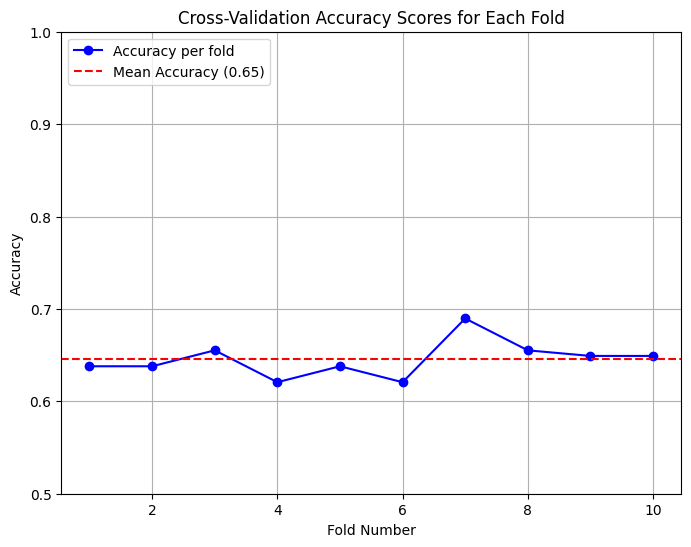

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', color='b', linestyle='-', label='Accuracy per fold')
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label=f'Mean Accuracy ({np.mean(cv_scores):.2f})')
plt.title('Cross-Validation Accuracy Scores for Each Fold')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

0.5451725075153278


<Axes: >

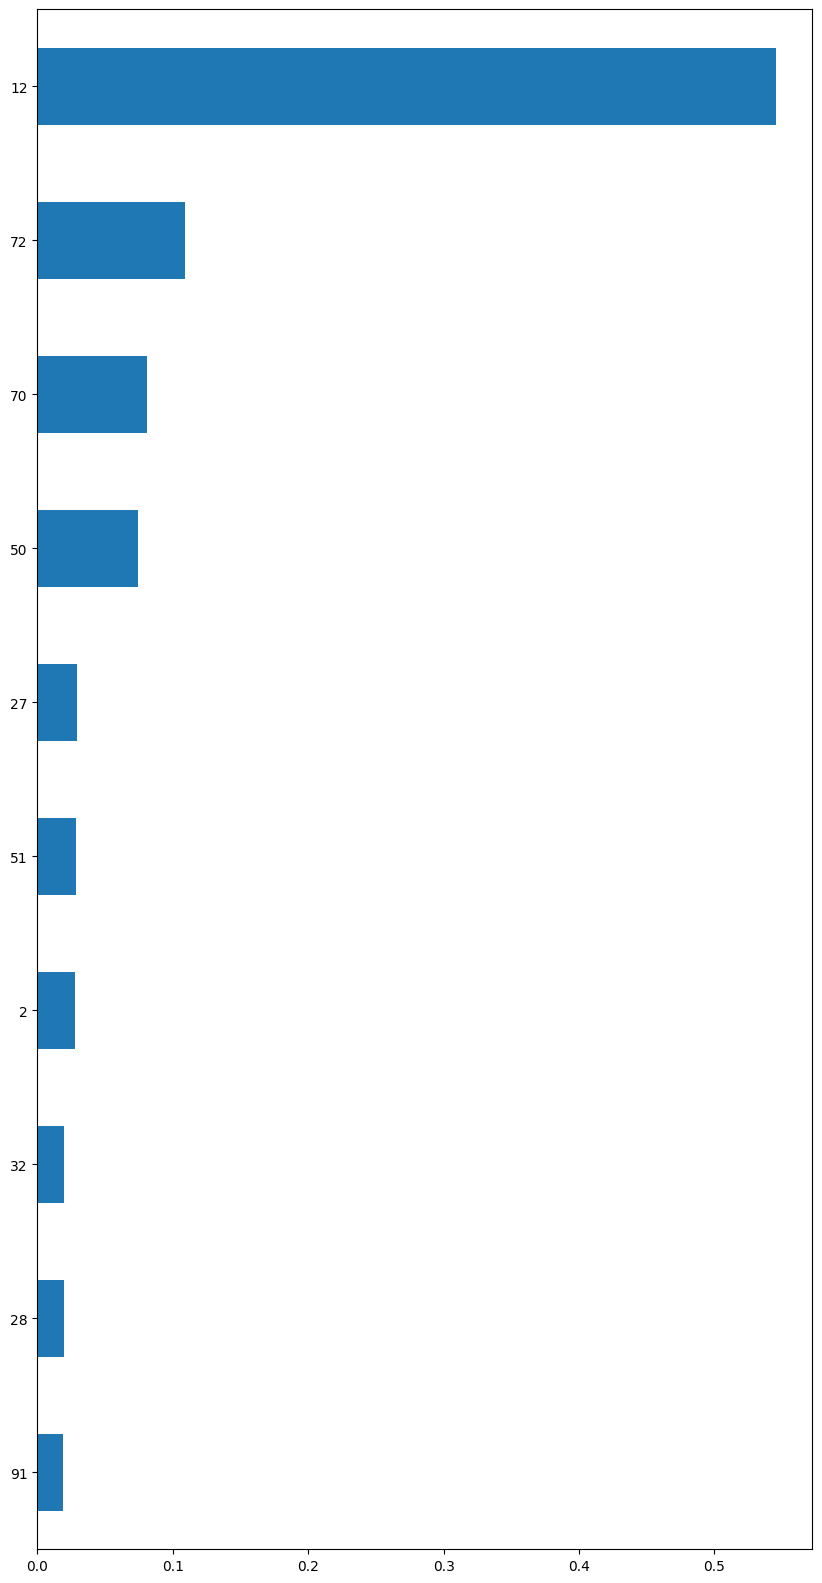

In [14]:

model.fit(volumes, labels)
feature_importance = pd.Series(model.feature_importances_)
print(max(feature_importance))
feature_importance.sort_values()[-10:].plot(kind="barh", figsize = (10, 20))

In [15]:

with parallel_backend('threading', n_jobs=8):

    model = HistGradientBoostingClassifier(learning_rate=0.1, max_leaf_nodes=10, max_depth=2, class_weight='balanced')

    # Need to implement k fold with non-leakage datasets, there could be leakage here if single_img_per_subject is not selected
    cv = StratifiedKFold(n_splits=10, shuffle=True)

    cv_scores = cross_val_score(model, volumes, labels, cv=cv, scoring='accuracy')

    print(f'Cross-validation accuracy scores: {cv_scores}')
    print(f'Mean cross-validation accuracy: {np.mean(cv_scores)}')
    print(f'Standard deviation of cross-validation accuracy: {np.std(cv_scores)}')

Cross-validation accuracy scores: [0.69 0.71 0.67 0.81 0.78 0.72 0.67 0.59 0.6  0.61]
Mean cross-validation accuracy: 0.6848457350272232
Standard deviation of cross-validation accuracy: 0.06996187149892628


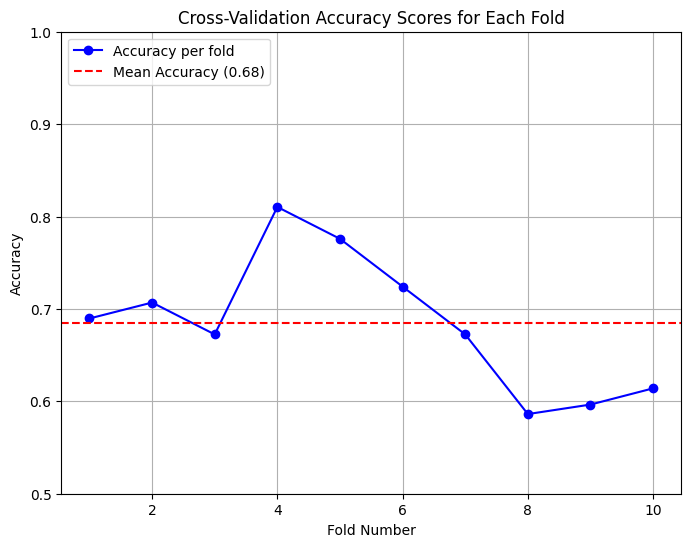

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', color='b', linestyle='-', label='Accuracy per fold')
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label=f'Mean Accuracy ({np.mean(cv_scores):.2f})')
plt.title('Cross-Validation Accuracy Scores for Each Fold')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()